# Boston house price regression
This notebook is for practising regression with Keras library. This example is taken from Deep Learning with Python by Françoic Chollet (highly recommended).

In [1]:
from keras.datasets import boston_housing
from keras import models, layers
from keras import regularizers
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.25)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Prepare dataset

In [2]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [3]:
print (train_data.shape)
print (test_data.shape)

(404, 13)
(102, 13)


In [4]:
# standardise features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
X_train = (train_data - mean) / std
X_test = (test_data - mean) / std
y_train = train_labels
y_test = test_labels

## 2. Build and train a network

Since the dataset is small, we need to use a small network to avoid overfitting.

The output layer has no activation function because we don't need any restriction on the output for a regression problem. A sigmoid function, for example, would restrict a layer to predict values between 0 and 1. 

`mse` = mean squared error  
`mae` = mean absolute error

In [10]:
def build_model(params):
    model = models.Sequential()
    
    model.add(layers.Dense(params['n_unit_dense_1'], 
                           kernel_regularizer=regularizers.l1_l2(l1=params['l1_dense_1'], l2=params['l2_dense_1']),
                           activation='relu', 
                           input_shape=(13,)))
    
    model.add(layers.Dropout(rate=params['rate_dropout_1']))
    
    model.add(layers.Dense(params['n_unit_dense_2'], 
                           kernel_regularizer=regularizers.l1_l2(l1=params['l1_dense_2'], l2=params['l2_dense_2']),
                           activation='relu'))
    
    model.add(layers.Dropout(rate=params['rate_dropout_2']))
    
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Since there is only a small amount of training data, using cross validation would provide a better estimation of the metrics.

In [9]:
def cross_validation(model_func, model_params, X, y, k, n_epochs, batch_size, verbose=0):
    results = {}
    
    kf = KFold(n_splits=k)
    
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        print('processing fold #', i)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = model_func(model_params)
        history = model.fit(x=X_train,
                            y=y_train,
                            epochs=n_epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            verbose=verbose)
        
        # mae scores
        val_score = model.evaluate(X_val, y_val, verbose=verbose)
        
        # saving fold result
        results[i] = {'model': model, 'history': history, 'val_score': val_score}
        
    return results

The following experiments compare three different regularisation methods vs no regularisation:

1. Weight regularisation
2. Dropout
3. Weight regularisation + Dropout

In [73]:
experiments = {
    'baseline': {
        'model_params': {'n_unit_dense_1': 64, 'l1_dense_1': 0., 'l2_dense_1': 0., 'rate_dropout_1': 0.,
                         'n_unit_dense_2': 64, 'l1_dense_2': 0., 'l2_dense_2': 0., 'rate_dropout_2': 0.,},
    },
    'weight_reg': {
        'model_params': {'n_unit_dense_1': 64, 'l1_dense_1': 0.05, 'l2_dense_1': 0.05, 'rate_dropout_1': 0.,
                         'n_unit_dense_2': 64, 'l1_dense_2': 0.05, 'l2_dense_2': 0.05, 'rate_dropout_2': 0.,},
    },
    'dropout': {
        'model_params': {'n_unit_dense_1': 64, 'l1_dense_1': 0., 'l2_dense_1': 0., 'rate_dropout_1': 0.2,
                         'n_unit_dense_2': 64, 'l1_dense_2': 0., 'l2_dense_2': 0., 'rate_dropout_2': 0.2,}, 
    },
    'weight_reg_and_dropout': {
        'model_params': {'n_unit_dense_1': 64, 'l1_dense_1': 0.05, 'l2_dense_1': 0.05, 'rate_dropout_1': 0.2,
                         'n_unit_dense_2': 64, 'l1_dense_2': 0.05, 'l2_dense_2': 0.05, 'rate_dropout_2': 0.2,},
    },
}

In [74]:
k_fold = 5
n_epochs = 100

for exp_name, exp_config in experiments.items():
    print(f'Running experiment: {exp_name}')
    
    results = cross_validation(model_func=build_model, 
                               model_params=exp_config['model_params'], 
                               X=X_train, 
                               y=y_train, 
                               k=k_fold, 
                               n_epochs=n_epochs, 
                               batch_size=1, 
                               verbose=0)
    
    # calculate average values of each metric
    metric_avg = {}
    for metric in ['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error']:
        m = np.array([res['history'].history[metric] for fold, res in results.items()])
        metric_avg[metric] = m.mean(axis=0)
        
    # saving results
    experiments[exp_name]['results'] = results
    experiments[exp_name]['metric_avg'] = metric_avg

Running experiment: baseline
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Running experiment: weight_reg
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Running experiment: dropout
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Running experiment: weight_reg_and_dropout
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


## 3. Results

In [71]:
def plot_metric_vs_epochs(data, title, **set_kwargs):
    epochs = range(1, len(data['loss'])+1)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(title, fontsize=20)
    ax[0].plot(epochs, data['loss'], 'bo', label='training loss')
    ax[0].plot(epochs, data['val_loss'], 'bx', label='validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set(xlabel='Epochs', ylabel='Loss')
    ax[0].legend()
    ax[0].set(**set_kwargs)

    ax[1].plot(epochs, data['mean_absolute_error'], 'bo', label='training mae')
    ax[1].plot(epochs, data['val_mean_absolute_error'], 'bx', label='validation mae')
    ax[1].set_title('Training and validation MAE')
    ax[1].set(xlabel='Epochs', ylabel='MAE')
    ax[1].legend()
    ax[1].set(**set_kwargs)

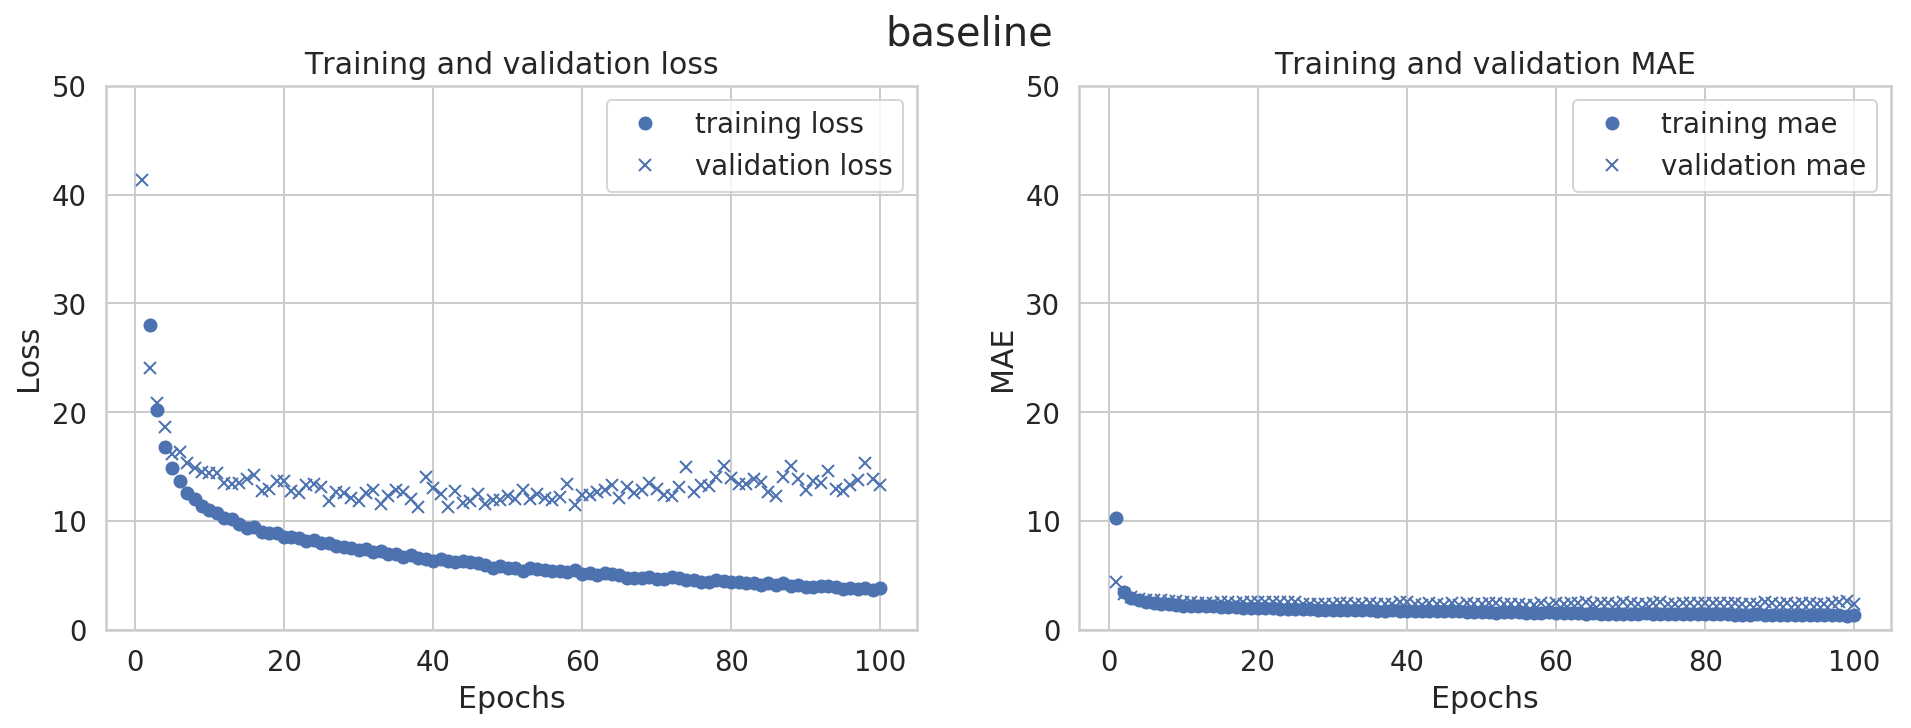

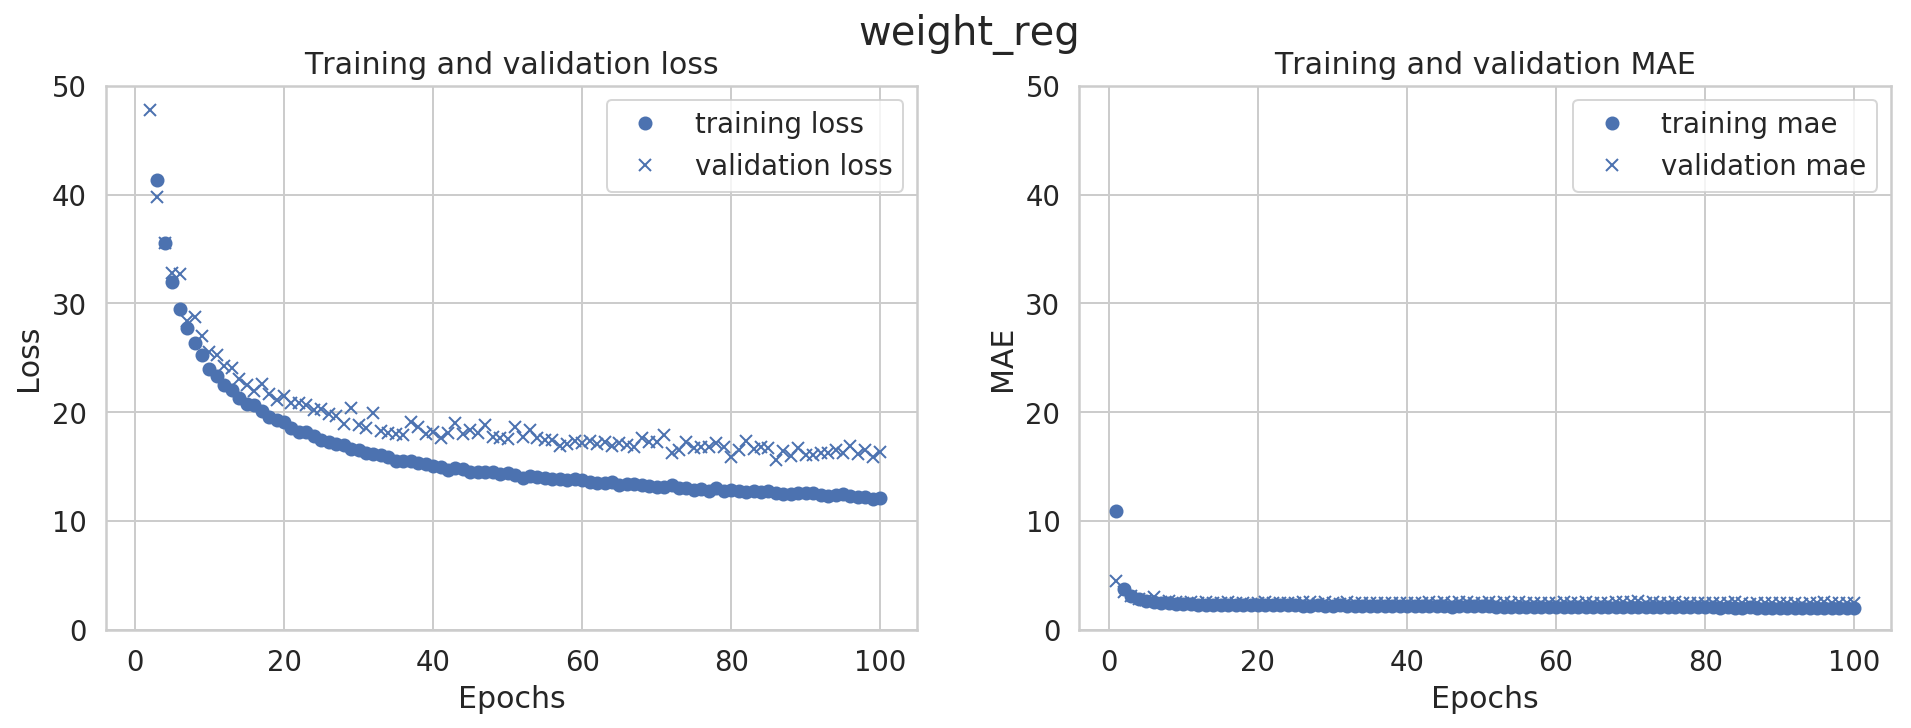

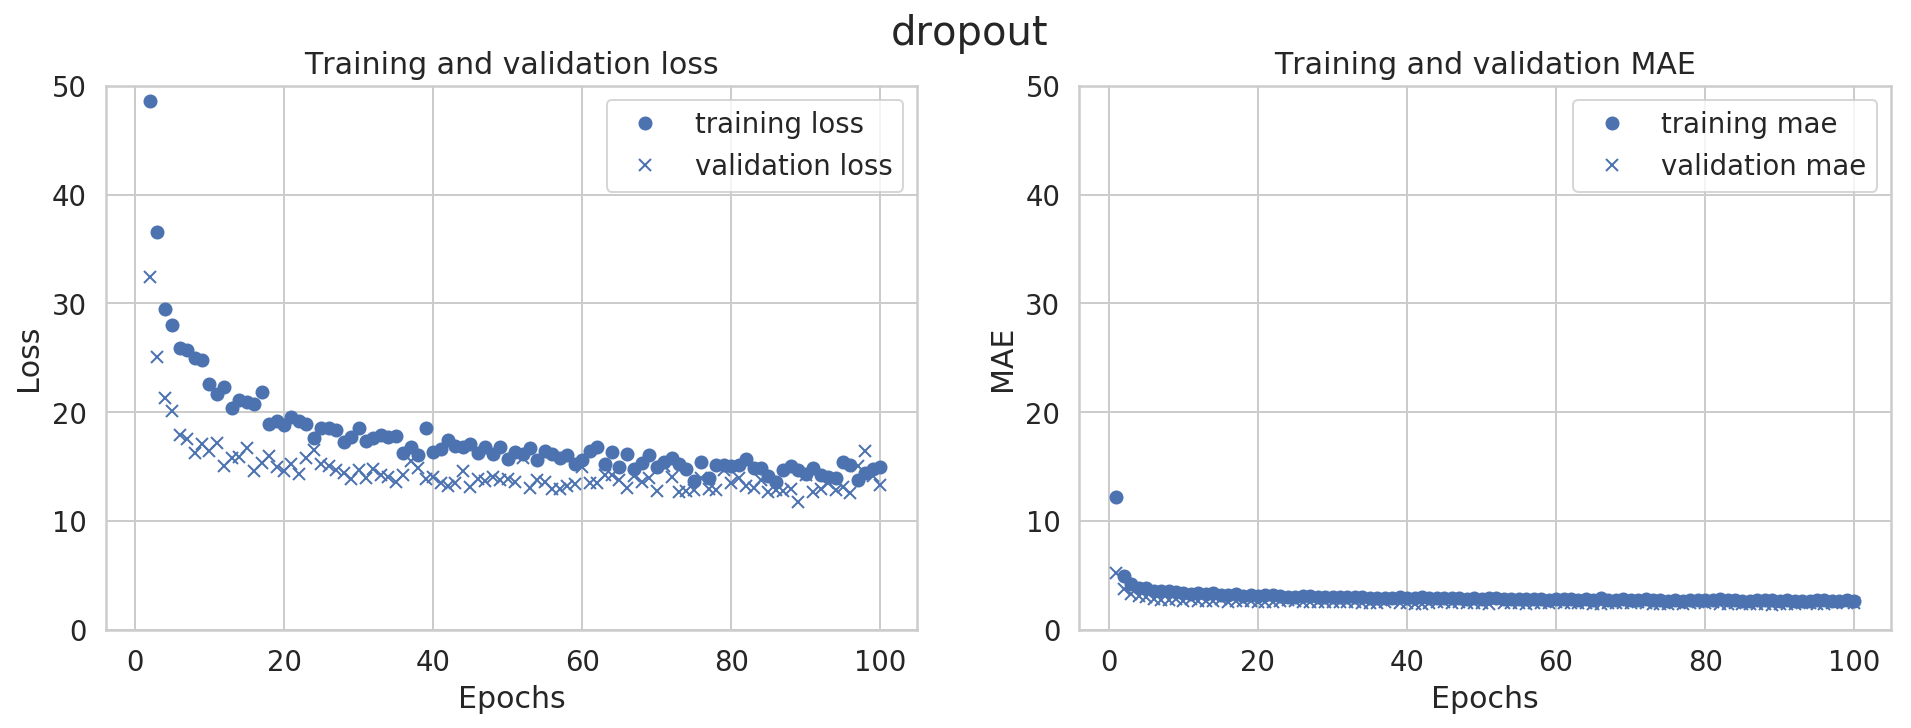

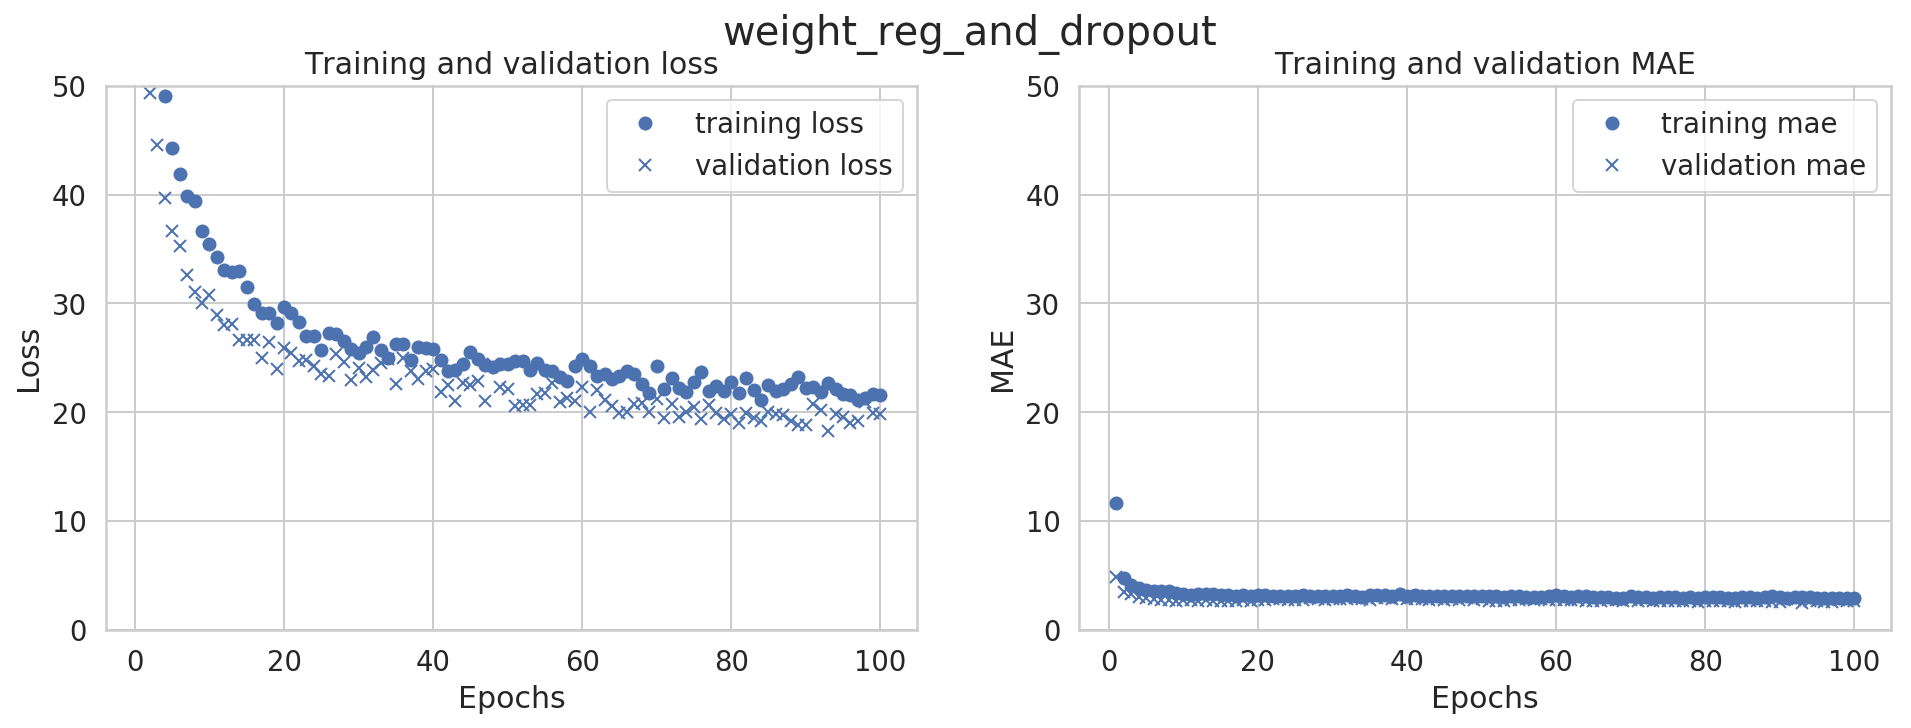

In [75]:
for exp_name, exp_config in experiments.items():
    plot_metric_vs_epochs(exp_config['metric_avg'], title=exp_name, ylim=(0, 50))
    plt.show()

We can see from the figures above, both weight regularisation and dropout are able to reduce overfitting (comparing the gap between the training and vadiation curves).